# **Bionsight Technical Challenge**



## Google Drive Mount



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Temp
%ls -l

/content/drive/MyDrive/Temp
total 5406
-rw------- 1 root root 2472699 Apr  4 17:04  BestMPNN-QM9.pth
-rw------- 1 root root 2472699 Apr  4 17:04  checkpoint.pth.tar
-rw------- 1 root root  530832 Apr  1 19:26  cmpd.csv
-rw------- 1 root root   19019 Apr  3 12:59 '바이온사이트 과제.ipynb'
-rw------- 1 root root   39403 Apr  4 17:14 'Technical Challenge.ipynb'


## =============== MPNN ===============

### Installation for PyTorch Geometric Library



In [ ]:
# Install Required Packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q karateclub 
!pip install rdkit-pypi -qqq

     |████████████████████████████████| 7.9 MB 12.9 MB/s 
     |████████████████████████████████| 3.5 MB 15.5 MB/s 
     |████████████████████████████████| 62 kB 670 kB/s 
     |████████████████████████████████| 1.8 MB 29.8 MB/s 
     |████████████████████████████████| 24.1 MB 78.3 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 22.5 MB 492 kB/s 


### Library Import



In [ ]:
import shutil
import time
from tqdm import tqdm

import os.path as osp
import torch
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops

### Preprocessing



In [ ]:
target = 0
dim = 64

class MyTransform(object):
    def __call__(self, data):
        data.y = data.y[:, target]
        return data

class Complete(object):
    def __call__(self, data):
        device = data.edge_index.device
        row = torch.arange(data.num_nodes, dtype = torch.long, device = device)
        col = torch.arange(data.num_nodes, dtype = torch.long, device = device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim = 0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index
        return data

### Dataset Loading



In [ ]:
path = '/QM9'
transform = T.Compose([MyTransform(), Complete(), T.Distance(norm = False)])
dataset = QM9(root = path, transform = transform).shuffle()
data = dataset[2]

Extracting /QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:57<00:00, 755.62it/s]
Done!


In [ ]:
print('Dataset : {}'.format(dataset)) 
print('======================================================')
print('Number of graphs : {}'.format(len(dataset)))
print('Number of features : {}'.format(dataset.num_features))
print('Number of classes : {}'.format(dataset.num_classes))

Dataset : QM9(130831)
Number of graphs : 130831
Number of features : 11
Number of classes : 19


In [ ]:
print(data) # Single data
print('=======================================================')

# Gather some statistics about the graph.
print('Number of nodes : {}'.format(data.num_nodes))
print('Number of edges : {}'.format(data.num_edges))
print('Average node degree : {:.2f}'.format(data.num_edges / data.num_nodes))

# Methods
print('Has isolated nodes : {}'.format(data.has_isolated_nodes()))
print('Has self-loops : {}'.format(data.has_self_loops()))
print('Is undirected : {}'.format(data.is_undirected()))

Data(x=[17, 11], edge_index=[2, 272], edge_attr=[272, 5], y=[1], pos=[17, 3], z=[17], name='gdb_67280', idx=[1])
Number of nodes : 17
Number of edges : 272
Average node degree : 16.00
Has isolated nodes : False
Has self-loops : False
Is undirected : True


In [ ]:
# Normalize targets to mean = 0 and std = 1
mean = dataset.data.y.mean(dim = 0, keepdim = True)
std  = dataset.data.y.std(dim = 0, keepdim = True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()
print('Mean : {}, Std : {}'.format(mean, std))

Mean : 2.672952651977539, Std : 1.5034793615341187


In [ ]:
# Split datasets.
train_dataset = dataset[:110000]
valid_dataset = dataset[110000:125000]
test_dataset  = dataset[125000:]

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)
test_loader  = DataLoader(test_dataset,  batch_size = 128, shuffle = False)

print(len(train_loader.dataset))
print(len(valid_loader.dataset))
print(len(test_loader.dataset))

110000
15000
5831


### Modeling

* PyG Implementation according to Message Passing Neural Network Paper.



In [ ]:
class MPNN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.node_embedding = torch.nn.Linear(dataset.num_features, 92)  # later removed
        self.edge_embedding = torch.nn.Linear(5, 22)                     # later removed
        self.lin0 = torch.nn.Linear(92, dim)

        nn = Sequential(Linear(22, 128), ReLU(), Linear(128, dim * dim)) # 22가 edge dim
        self.conv = NNConv(in_channels = dim, out_channels = dim, nn = nn, aggr = 'mean')
        self.gru = GRU(dim, dim)

        self.set2set = Set2Set(in_channels = dim, processing_steps = 3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)

    def forward(self, data):
        data.x = F.relu(self.node_embedding(data.x)) # node embedding
        out = F.relu(self.lin0(data.x))              # node dimension --> dim 으로 변환
        h = out.unsqueeze(0)

        data.edge_attr = F.relu(self.edge_embedding(data.edge_attr))    # edge embedding
        
        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr)) # MPNN Convolution : dim 유지
            out, h = self.gru(m.unsqueeze(0), h) # dim 유지
            out = out.squeeze(0)
        out = self.set2set(out, data.batch)      # dim -> 2 * dim
        out = F.relu(self.lin1(out))             # 2 * dim --> dim
        out = self.lin2(out)                     # dim --> 1
        return out.view(-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',
                                                       factor = 0.7, patience = 5, min_lr = 0.00001) # LR Scheduler
print('Device : {}'.format(device))
print('Model : {}'.format(model))
print('Optimizer : {}'.format(optimizer))
print('Scheduler : {}'.format(scheduler))

Device : cuda
Model : MPNN(
  (node_embedding): Linear(in_features=11, out_features=92, bias=True)
  (edge_embedding): Linear(in_features=5, out_features=22, bias=True)
  (lin0): Linear(in_features=92, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0005
)
Scheduler : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fc9dba7e0d0>


### Training / Validation / Test



In [ ]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        loss = F.mse_loss(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset) # Average MSE loss per epoch

def test(loader):
    model.eval()
    error = 0
    for data in tqdm(loader):
        data = data.to(device)
        error += (model(data) * std - data.y * std).abs().sum().item() 
    return error / len(loader.dataset) # Aaverage MAE loss per epoch

In [15]:
best_val_error = None
model_path = './BestMPNN-QM9.pth'
train_losses = []
valid_losses = []

start_time = time.time()
for epoch in range(1, 301):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)             # Traininig
    val_error = test(valid_loader)  # Validation
    scheduler.step(val_error)       # LR Scheduler by val error

    train_losses.append(loss)
    valid_losses.append(val_error)

    # ------------------------------ Save Best Model ---------------------------------------------
    torch.save(model.state_dict(), 'checkpoint.pth.tar')       # Epoch마다 모델의 state dict를 checkpoint로 저장
    if best_val_error is None or val_error <= best_val_error:  # validation error 기준
        test_error = test(test_loader)                         
        best_val_error = val_error
        shutil.copyfile('checkpoint.pth.tar', model_path)      # checkpoint를 best model로 복사 저장

    print('Epoch : {:03d}, LR : {:7f}, Loss : {:.7f}, Val MAE : {:.7f}, Test MAE : {:.7f}'.format(
        epoch, lr, loss, val_error, test_error))

print('\nElapsed Time : {:.4f} secs'.format(time.time() - start_time)) # sec
print('Training Completed!!')  # output removed!

100%|██████████| 46/46 [00:04<00:00,  9.92it/s]


Epoch : 001, LR : 0.001000, Loss : 0.5994737, Val MAE : 0.6717269, Test MAE : 0.6771312


100%|██████████| 46/46 [00:03<00:00, 12.27it/s]


Epoch : 002, LR : 0.001000, Loss : 0.2982627, Val MAE : 0.5026604, Test MAE : 0.5043957


100%|██████████| 46/46 [00:03<00:00, 12.47it/s]


Epoch : 003, LR : 0.001000, Loss : 0.1832770, Val MAE : 0.3882531, Test MAE : 0.3942722


100%|██████████| 46/46 [00:03<00:00, 12.48it/s]


Epoch : 004, LR : 0.001000, Loss : 0.1247092, Val MAE : 0.3379496, Test MAE : 0.3368124


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 005, LR : 0.001000, Loss : 0.1048468, Val MAE : 0.3559199, Test MAE : 0.3368124


100%|██████████| 46/46 [00:03<00:00, 12.35it/s]


Epoch : 006, LR : 0.001000, Loss : 0.0881922, Val MAE : 0.3008362, Test MAE : 0.3066261


100%|██████████| 46/46 [00:03<00:00, 12.40it/s]


Epoch : 007, LR : 0.001000, Loss : 0.0802337, Val MAE : 0.2904152, Test MAE : 0.2858220


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Epoch : 008, LR : 0.001000, Loss : 0.0745470, Val MAE : 0.3180994, Test MAE : 0.2858220


100%|██████████| 46/46 [00:03<00:00, 12.32it/s]


Epoch : 009, LR : 0.001000, Loss : 0.0654997, Val MAE : 0.2631908, Test MAE : 0.2699426


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 010, LR : 0.001000, Loss : 0.0657877, Val MAE : 0.2933254, Test MAE : 0.2699426


100%|██████████| 46/46 [00:03<00:00, 12.40it/s]


Epoch : 011, LR : 0.001000, Loss : 0.0600073, Val MAE : 0.2533488, Test MAE : 0.2553225


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 012, LR : 0.001000, Loss : 0.0590955, Val MAE : 0.2638573, Test MAE : 0.2553225


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 013, LR : 0.001000, Loss : 0.0557360, Val MAE : 0.2757399, Test MAE : 0.2553225


100%|██████████| 59/59 [00:09<00:00,  6.37it/s]


Epoch : 014, LR : 0.001000, Loss : 0.0657507, Val MAE : 0.3445555, Test MAE : 0.2553225


100%|██████████| 46/46 [00:03<00:00, 12.24it/s]


Epoch : 015, LR : 0.001000, Loss : 0.0585103, Val MAE : 0.2319316, Test MAE : 0.2330848


100%|██████████| 46/46 [00:03<00:00, 12.18it/s]


Epoch : 016, LR : 0.001000, Loss : 0.0473812, Val MAE : 0.2226192, Test MAE : 0.2235143


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 017, LR : 0.001000, Loss : 0.0475607, Val MAE : 0.2473368, Test MAE : 0.2235143


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Epoch : 018, LR : 0.001000, Loss : 0.0469821, Val MAE : 0.2532534, Test MAE : 0.2235143


100%|██████████| 59/59 [00:09<00:00,  6.46it/s]


Epoch : 019, LR : 0.001000, Loss : 0.0468390, Val MAE : 0.2449726, Test MAE : 0.2235143


100%|██████████| 59/59 [00:10<00:00,  5.70it/s]


Epoch : 020, LR : 0.001000, Loss : 0.0452168, Val MAE : 0.2491106, Test MAE : 0.2235143


100%|██████████| 59/59 [00:09<00:00,  6.18it/s]


Epoch : 021, LR : 0.001000, Loss : 0.0456193, Val MAE : 0.2300836, Test MAE : 0.2235143


100%|██████████| 46/46 [00:03<00:00, 11.82it/s]


Epoch : 022, LR : 0.001000, Loss : 0.0422850, Val MAE : 0.2161446, Test MAE : 0.2238869


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Epoch : 023, LR : 0.001000, Loss : 0.0416624, Val MAE : 0.2332727, Test MAE : 0.2238869


100%|██████████| 46/46 [00:03<00:00, 12.04it/s]


Epoch : 024, LR : 0.001000, Loss : 0.0415688, Val MAE : 0.2132380, Test MAE : 0.2151667


100%|██████████| 46/46 [00:03<00:00, 12.18it/s]


Epoch : 025, LR : 0.001000, Loss : 0.0442976, Val MAE : 0.2035613, Test MAE : 0.2047504


100%|██████████| 59/59 [00:09<00:00,  6.27it/s]


Epoch : 026, LR : 0.001000, Loss : 0.0397477, Val MAE : 0.2437738, Test MAE : 0.2047504


100%|██████████| 46/46 [00:03<00:00, 12.36it/s]


Epoch : 027, LR : 0.001000, Loss : 0.0395379, Val MAE : 0.1945222, Test MAE : 0.1960215


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 028, LR : 0.001000, Loss : 0.0387774, Val MAE : 0.2006294, Test MAE : 0.1960215


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 029, LR : 0.001000, Loss : 0.0373042, Val MAE : 0.2029680, Test MAE : 0.1960215


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Epoch : 030, LR : 0.001000, Loss : 0.0362063, Val MAE : 0.2215075, Test MAE : 0.1960215


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Epoch : 031, LR : 0.001000, Loss : 0.0375528, Val MAE : 0.2143216, Test MAE : 0.1960215


100%|██████████| 46/46 [00:03<00:00, 12.18it/s]


Epoch : 032, LR : 0.001000, Loss : 0.0376395, Val MAE : 0.1857921, Test MAE : 0.1905309


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Epoch : 033, LR : 0.001000, Loss : 0.0361605, Val MAE : 0.1950534, Test MAE : 0.1905309


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 034, LR : 0.001000, Loss : 0.0375091, Val MAE : 0.1942937, Test MAE : 0.1905309


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 035, LR : 0.001000, Loss : 0.0348373, Val MAE : 0.2205893, Test MAE : 0.1905309


100%|██████████| 59/59 [00:09<00:00,  6.00it/s]


Epoch : 036, LR : 0.001000, Loss : 0.0384720, Val MAE : 0.2168785, Test MAE : 0.1905309


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 037, LR : 0.001000, Loss : 0.0337381, Val MAE : 0.2042904, Test MAE : 0.1905309


100%|██████████| 46/46 [00:03<00:00, 12.27it/s]


Epoch : 038, LR : 0.001000, Loss : 0.0334530, Val MAE : 0.1812868, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 039, LR : 0.001000, Loss : 0.0354746, Val MAE : 0.1872775, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 040, LR : 0.001000, Loss : 0.0338640, Val MAE : 0.1984045, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.31it/s]


Epoch : 041, LR : 0.001000, Loss : 0.0346517, Val MAE : 0.2752506, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Epoch : 042, LR : 0.001000, Loss : 0.0331529, Val MAE : 0.1901786, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 043, LR : 0.001000, Loss : 0.0341311, Val MAE : 0.2660566, Test MAE : 0.1853792


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Epoch : 044, LR : 0.001000, Loss : 0.0318416, Val MAE : 0.1969364, Test MAE : 0.1853792


100%|██████████| 46/46 [00:03<00:00, 12.14it/s]


Epoch : 045, LR : 0.000700, Loss : 0.0287776, Val MAE : 0.1756340, Test MAE : 0.1798229


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Epoch : 046, LR : 0.000700, Loss : 0.0281097, Val MAE : 0.1838580, Test MAE : 0.1798229


100%|██████████| 46/46 [00:03<00:00, 12.36it/s]


Epoch : 047, LR : 0.000700, Loss : 0.0291214, Val MAE : 0.1712228, Test MAE : 0.1742358


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 048, LR : 0.000700, Loss : 0.0289276, Val MAE : 0.1780848, Test MAE : 0.1742358


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Epoch : 049, LR : 0.000700, Loss : 0.0290662, Val MAE : 0.2045522, Test MAE : 0.1742358


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Epoch : 050, LR : 0.000700, Loss : 0.0282338, Val MAE : 0.1820999, Test MAE : 0.1742358


100%|██████████| 59/59 [00:09<00:00,  6.31it/s]


Epoch : 051, LR : 0.000700, Loss : 0.0279777, Val MAE : 0.2115475, Test MAE : 0.1742358


100%|██████████| 46/46 [00:03<00:00, 12.46it/s]


Epoch : 052, LR : 0.000700, Loss : 0.0277760, Val MAE : 0.1705180, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Epoch : 053, LR : 0.000700, Loss : 0.0289976, Val MAE : 0.2001801, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.53it/s]


Epoch : 054, LR : 0.000700, Loss : 0.0286575, Val MAE : 0.1794923, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.31it/s]


Epoch : 055, LR : 0.000700, Loss : 0.0275053, Val MAE : 0.2093906, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 056, LR : 0.000700, Loss : 0.0271911, Val MAE : 0.1958457, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Epoch : 057, LR : 0.000700, Loss : 0.0269121, Val MAE : 0.1715814, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 058, LR : 0.000700, Loss : 0.0277955, Val MAE : 0.1812173, Test MAE : 0.1724443


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 059, LR : 0.000490, Loss : 0.0243219, Val MAE : 0.1997912, Test MAE : 0.1724443


100%|██████████| 46/46 [00:03<00:00, 12.25it/s]


Epoch : 060, LR : 0.000490, Loss : 0.0241462, Val MAE : 0.1625550, Test MAE : 0.1642592


100%|██████████| 46/46 [00:03<00:00, 12.26it/s]


Epoch : 061, LR : 0.000490, Loss : 0.0252635, Val MAE : 0.1604773, Test MAE : 0.1636827


100%|██████████| 59/59 [00:09<00:00,  6.38it/s]


Epoch : 062, LR : 0.000490, Loss : 0.0245134, Val MAE : 0.1629805, Test MAE : 0.1636827


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 063, LR : 0.000490, Loss : 0.0239671, Val MAE : 0.1879610, Test MAE : 0.1636827


100%|██████████| 59/59 [00:09<00:00,  6.54it/s]


Epoch : 064, LR : 0.000490, Loss : 0.0242558, Val MAE : 0.1693605, Test MAE : 0.1636827


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


Epoch : 065, LR : 0.000490, Loss : 0.0244844, Val MAE : 0.1935902, Test MAE : 0.1636827


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 066, LR : 0.000490, Loss : 0.0250626, Val MAE : 0.1653087, Test MAE : 0.1636827


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Epoch : 067, LR : 0.000490, Loss : 0.0239802, Val MAE : 0.1674161, Test MAE : 0.1636827


100%|██████████| 46/46 [00:03<00:00, 12.41it/s]


Epoch : 068, LR : 0.000343, Loss : 0.0215882, Val MAE : 0.1554558, Test MAE : 0.1594780


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 069, LR : 0.000343, Loss : 0.0219247, Val MAE : 0.1646370, Test MAE : 0.1594780


100%|██████████| 46/46 [00:03<00:00, 12.54it/s]


Epoch : 070, LR : 0.000343, Loss : 0.0219152, Val MAE : 0.1537808, Test MAE : 0.1569702


100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Epoch : 071, LR : 0.000343, Loss : 0.0220060, Val MAE : 0.1706387, Test MAE : 0.1569702


100%|██████████| 46/46 [00:03<00:00, 12.22it/s]


Epoch : 072, LR : 0.000343, Loss : 0.0219748, Val MAE : 0.1520687, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Epoch : 073, LR : 0.000343, Loss : 0.0217304, Val MAE : 0.1614202, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 074, LR : 0.000343, Loss : 0.0215557, Val MAE : 0.1847404, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.37it/s]


Epoch : 075, LR : 0.000343, Loss : 0.0214772, Val MAE : 0.1697288, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 076, LR : 0.000343, Loss : 0.0221062, Val MAE : 0.1643590, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 077, LR : 0.000343, Loss : 0.0211496, Val MAE : 0.1622365, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.48it/s]


Epoch : 078, LR : 0.000343, Loss : 0.0212556, Val MAE : 0.1570684, Test MAE : 0.1552721


100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Epoch : 079, LR : 0.000240, Loss : 0.0196212, Val MAE : 0.1520963, Test MAE : 0.1552721


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Epoch : 080, LR : 0.000240, Loss : 0.0201504, Val MAE : 0.1607220, Test MAE : 0.1552721


100%|██████████| 46/46 [00:03<00:00, 12.74it/s]


Epoch : 081, LR : 0.000240, Loss : 0.0203599, Val MAE : 0.1510457, Test MAE : 0.1556743


100%|██████████| 59/59 [00:08<00:00,  6.65it/s]


Epoch : 082, LR : 0.000240, Loss : 0.0196232, Val MAE : 0.1719365, Test MAE : 0.1556743


100%|██████████| 59/59 [00:08<00:00,  6.62it/s]


Epoch : 083, LR : 0.000240, Loss : 0.0194138, Val MAE : 0.1516711, Test MAE : 0.1556743


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Epoch : 084, LR : 0.000240, Loss : 0.0196512, Val MAE : 0.1534604, Test MAE : 0.1556743


100%|██████████| 46/46 [00:03<00:00, 12.70it/s]


Epoch : 085, LR : 0.000240, Loss : 0.0198238, Val MAE : 0.1464627, Test MAE : 0.1506795


100%|██████████| 59/59 [00:08<00:00,  6.59it/s]


Epoch : 086, LR : 0.000240, Loss : 0.0198298, Val MAE : 0.1600943, Test MAE : 0.1506795


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Epoch : 087, LR : 0.000240, Loss : 0.0197414, Val MAE : 0.1600823, Test MAE : 0.1506795


100%|██████████| 59/59 [00:08<00:00,  6.60it/s]


Epoch : 088, LR : 0.000240, Loss : 0.0196435, Val MAE : 0.1654395, Test MAE : 0.1506795


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Epoch : 089, LR : 0.000240, Loss : 0.0197373, Val MAE : 0.1473039, Test MAE : 0.1506795


100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Epoch : 090, LR : 0.000240, Loss : 0.0203719, Val MAE : 0.1582055, Test MAE : 0.1506795


100%|██████████| 46/46 [00:03<00:00, 12.83it/s]


Epoch : 091, LR : 0.000240, Loss : 0.0194108, Val MAE : 0.1455240, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.73it/s]


Epoch : 092, LR : 0.000240, Loss : 0.0192526, Val MAE : 0.1551129, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


Epoch : 093, LR : 0.000240, Loss : 0.0193039, Val MAE : 0.1551431, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.79it/s]


Epoch : 094, LR : 0.000240, Loss : 0.0198547, Val MAE : 0.1586814, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.70it/s]


Epoch : 095, LR : 0.000240, Loss : 0.0190078, Val MAE : 0.1638142, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.77it/s]


Epoch : 096, LR : 0.000240, Loss : 0.0194621, Val MAE : 0.1464893, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


Epoch : 097, LR : 0.000240, Loss : 0.0191172, Val MAE : 0.1455978, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.80it/s]


Epoch : 098, LR : 0.000168, Loss : 0.0183691, Val MAE : 0.1501663, Test MAE : 0.1480220


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


Epoch : 099, LR : 0.000168, Loss : 0.0179465, Val MAE : 0.1502326, Test MAE : 0.1480220


100%|██████████| 46/46 [00:03<00:00, 13.26it/s]


Epoch : 100, LR : 0.000168, Loss : 0.0183231, Val MAE : 0.1432997, Test MAE : 0.1480256


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]


Epoch : 101, LR : 0.000168, Loss : 0.0182056, Val MAE : 0.1517808, Test MAE : 0.1480256


100%|██████████| 59/59 [00:08<00:00,  6.76it/s]


Epoch : 102, LR : 0.000168, Loss : 0.0181958, Val MAE : 0.1462050, Test MAE : 0.1480256


100%|██████████| 59/59 [00:08<00:00,  6.86it/s]


Epoch : 103, LR : 0.000168, Loss : 0.0180431, Val MAE : 0.1538682, Test MAE : 0.1480256


100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Epoch : 104, LR : 0.000168, Loss : 0.0180875, Val MAE : 0.1471911, Test MAE : 0.1480256


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Epoch : 105, LR : 0.000168, Loss : 0.0183831, Val MAE : 0.1476927, Test MAE : 0.1480256


100%|██████████| 46/46 [00:03<00:00, 13.17it/s]


Epoch : 106, LR : 0.000168, Loss : 0.0179539, Val MAE : 0.1422153, Test MAE : 0.1464929


100%|██████████| 59/59 [00:08<00:00,  6.73it/s]


Epoch : 107, LR : 0.000168, Loss : 0.0180794, Val MAE : 0.1485734, Test MAE : 0.1464929


100%|██████████| 59/59 [00:08<00:00,  6.72it/s]


Epoch : 108, LR : 0.000168, Loss : 0.0179117, Val MAE : 0.1473624, Test MAE : 0.1464929


100%|██████████| 59/59 [00:08<00:00,  6.78it/s]


Epoch : 109, LR : 0.000168, Loss : 0.0182799, Val MAE : 0.1442347, Test MAE : 0.1464929


100%|██████████| 59/59 [00:09<00:00,  6.54it/s]


Epoch : 110, LR : 0.000168, Loss : 0.0180633, Val MAE : 0.1463154, Test MAE : 0.1464929


100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


Epoch : 111, LR : 0.000168, Loss : 0.0179054, Val MAE : 0.1455705, Test MAE : 0.1464929


100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Epoch : 112, LR : 0.000168, Loss : 0.0178816, Val MAE : 0.1486879, Test MAE : 0.1464929


100%|██████████| 46/46 [00:03<00:00, 12.68it/s]


Epoch : 113, LR : 0.000118, Loss : 0.0171271, Val MAE : 0.1421621, Test MAE : 0.1456396


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 114, LR : 0.000118, Loss : 0.0169140, Val MAE : 0.1460689, Test MAE : 0.1456396


100%|██████████| 59/59 [00:08<00:00,  6.70it/s]


Epoch : 115, LR : 0.000118, Loss : 0.0170344, Val MAE : 0.1422441, Test MAE : 0.1456396


100%|██████████| 46/46 [00:03<00:00, 12.90it/s]


Epoch : 116, LR : 0.000118, Loss : 0.0170409, Val MAE : 0.1394697, Test MAE : 0.1439105


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Epoch : 117, LR : 0.000118, Loss : 0.0169394, Val MAE : 0.1437515, Test MAE : 0.1439105


100%|██████████| 59/59 [00:08<00:00,  6.65it/s]


Epoch : 118, LR : 0.000118, Loss : 0.0171206, Val MAE : 0.1433802, Test MAE : 0.1439105


100%|██████████| 46/46 [00:03<00:00, 12.71it/s]


Epoch : 119, LR : 0.000118, Loss : 0.0170168, Val MAE : 0.1381788, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 120, LR : 0.000118, Loss : 0.0169269, Val MAE : 0.1474500, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 121, LR : 0.000118, Loss : 0.0170091, Val MAE : 0.1442613, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Epoch : 122, LR : 0.000118, Loss : 0.0169780, Val MAE : 0.1459224, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.79it/s]


Epoch : 123, LR : 0.000118, Loss : 0.0169522, Val MAE : 0.1399661, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Epoch : 124, LR : 0.000118, Loss : 0.0167930, Val MAE : 0.1422062, Test MAE : 0.1433980


100%|██████████| 59/59 [00:08<00:00,  6.79it/s]


Epoch : 125, LR : 0.000118, Loss : 0.0168314, Val MAE : 0.1420303, Test MAE : 0.1433980


100%|██████████| 46/46 [00:03<00:00, 12.94it/s]


Epoch : 126, LR : 0.000082, Loss : 0.0161541, Val MAE : 0.1378773, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.80it/s]


Epoch : 127, LR : 0.000082, Loss : 0.0161917, Val MAE : 0.1435104, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.73it/s]


Epoch : 128, LR : 0.000082, Loss : 0.0161652, Val MAE : 0.1404708, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]


Epoch : 129, LR : 0.000082, Loss : 0.0160829, Val MAE : 0.1524827, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]


Epoch : 130, LR : 0.000082, Loss : 0.0160716, Val MAE : 0.1401804, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.72it/s]


Epoch : 131, LR : 0.000082, Loss : 0.0162747, Val MAE : 0.1421840, Test MAE : 0.1412430


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 132, LR : 0.000082, Loss : 0.0162067, Val MAE : 0.1381474, Test MAE : 0.1412430


100%|██████████| 46/46 [00:03<00:00, 12.71it/s]


Epoch : 133, LR : 0.000058, Loss : 0.0155561, Val MAE : 0.1373685, Test MAE : 0.1404507


100%|██████████| 46/46 [00:03<00:00, 12.92it/s]


Epoch : 134, LR : 0.000058, Loss : 0.0156556, Val MAE : 0.1370004, Test MAE : 0.1408126


100%|██████████| 59/59 [00:08<00:00,  6.62it/s]


Epoch : 135, LR : 0.000058, Loss : 0.0156321, Val MAE : 0.1450925, Test MAE : 0.1408126


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Epoch : 136, LR : 0.000058, Loss : 0.0156814, Val MAE : 0.1377509, Test MAE : 0.1408126


100%|██████████| 59/59 [00:08<00:00,  6.78it/s]


Epoch : 137, LR : 0.000058, Loss : 0.0156556, Val MAE : 0.1426303, Test MAE : 0.1408126


100%|██████████| 46/46 [00:03<00:00, 12.63it/s]


Epoch : 138, LR : 0.000058, Loss : 0.0156170, Val MAE : 0.1346741, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.62it/s]


Epoch : 139, LR : 0.000058, Loss : 0.0156319, Val MAE : 0.1392992, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Epoch : 140, LR : 0.000058, Loss : 0.0155761, Val MAE : 0.1396249, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.63it/s]


Epoch : 141, LR : 0.000058, Loss : 0.0156237, Val MAE : 0.1369551, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 142, LR : 0.000058, Loss : 0.0155466, Val MAE : 0.1375422, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.65it/s]


Epoch : 143, LR : 0.000058, Loss : 0.0155143, Val MAE : 0.1379592, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.59it/s]


Epoch : 144, LR : 0.000058, Loss : 0.0155376, Val MAE : 0.1375201, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 145, LR : 0.000040, Loss : 0.0152997, Val MAE : 0.1350824, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Epoch : 146, LR : 0.000040, Loss : 0.0151499, Val MAE : 0.1363374, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


Epoch : 147, LR : 0.000040, Loss : 0.0151804, Val MAE : 0.1353273, Test MAE : 0.1390292


100%|██████████| 59/59 [00:09<00:00,  6.23it/s]


Epoch : 148, LR : 0.000040, Loss : 0.0151288, Val MAE : 0.1355737, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.79it/s]


Epoch : 149, LR : 0.000040, Loss : 0.0151628, Val MAE : 0.1365561, Test MAE : 0.1390292


100%|██████████| 59/59 [00:08<00:00,  6.90it/s]


Epoch : 150, LR : 0.000040, Loss : 0.0151179, Val MAE : 0.1353668, Test MAE : 0.1390292


100%|██████████| 46/46 [00:03<00:00, 13.37it/s]


Epoch : 151, LR : 0.000028, Loss : 0.0148907, Val MAE : 0.1342510, Test MAE : 0.1384591


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


Epoch : 152, LR : 0.000028, Loss : 0.0148445, Val MAE : 0.1363865, Test MAE : 0.1384591


100%|██████████| 59/59 [00:08<00:00,  6.80it/s]


Epoch : 153, LR : 0.000028, Loss : 0.0149490, Val MAE : 0.1355071, Test MAE : 0.1384591


100%|██████████| 46/46 [00:03<00:00, 13.28it/s]


Epoch : 154, LR : 0.000028, Loss : 0.0149327, Val MAE : 0.1331262, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


Epoch : 155, LR : 0.000028, Loss : 0.0148389, Val MAE : 0.1361532, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.82it/s]


Epoch : 156, LR : 0.000028, Loss : 0.0148630, Val MAE : 0.1354555, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.80it/s]


Epoch : 157, LR : 0.000028, Loss : 0.0149467, Val MAE : 0.1346306, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.76it/s]


Epoch : 158, LR : 0.000028, Loss : 0.0148897, Val MAE : 0.1339007, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.76it/s]


Epoch : 159, LR : 0.000028, Loss : 0.0148003, Val MAE : 0.1339989, Test MAE : 0.1376526


100%|██████████| 59/59 [00:08<00:00,  6.77it/s]


Epoch : 160, LR : 0.000028, Loss : 0.0148232, Val MAE : 0.1350598, Test MAE : 0.1376526


100%|██████████| 46/46 [00:03<00:00, 12.46it/s]


Epoch : 161, LR : 0.000020, Loss : 0.0146417, Val MAE : 0.1331062, Test MAE : 0.1375472


100%|██████████| 59/59 [00:09<00:00,  6.53it/s]


Epoch : 162, LR : 0.000020, Loss : 0.0146871, Val MAE : 0.1336641, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Epoch : 163, LR : 0.000020, Loss : 0.0146220, Val MAE : 0.1332745, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.72it/s]


Epoch : 164, LR : 0.000020, Loss : 0.0146450, Val MAE : 0.1341369, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]


Epoch : 165, LR : 0.000020, Loss : 0.0145942, Val MAE : 0.1339037, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.59it/s]


Epoch : 166, LR : 0.000020, Loss : 0.0146528, Val MAE : 0.1332983, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Epoch : 167, LR : 0.000020, Loss : 0.0146165, Val MAE : 0.1338680, Test MAE : 0.1375472


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]


Epoch : 168, LR : 0.000014, Loss : 0.0144829, Val MAE : 0.1338842, Test MAE : 0.1375472


100%|██████████| 46/46 [00:03<00:00, 12.72it/s]


Epoch : 169, LR : 0.000014, Loss : 0.0144939, Val MAE : 0.1327068, Test MAE : 0.1375099


100%|██████████| 59/59 [00:08<00:00,  6.59it/s]


Epoch : 170, LR : 0.000014, Loss : 0.0145136, Val MAE : 0.1330509, Test MAE : 0.1375099


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Epoch : 171, LR : 0.000014, Loss : 0.0144804, Val MAE : 0.1331258, Test MAE : 0.1375099


100%|██████████| 59/59 [00:08<00:00,  6.59it/s]


Epoch : 172, LR : 0.000014, Loss : 0.0144833, Val MAE : 0.1345329, Test MAE : 0.1375099


100%|██████████| 59/59 [00:09<00:00,  6.55it/s]


Epoch : 173, LR : 0.000014, Loss : 0.0144704, Val MAE : 0.1332261, Test MAE : 0.1375099


100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


Epoch : 174, LR : 0.000014, Loss : 0.0144642, Val MAE : 0.1331217, Test MAE : 0.1375099


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 175, LR : 0.000014, Loss : 0.0144431, Val MAE : 0.1332524, Test MAE : 0.1375099


100%|██████████| 46/46 [00:03<00:00, 12.65it/s]


Epoch : 176, LR : 0.000010, Loss : 0.0143604, Val MAE : 0.1323489, Test MAE : 0.1370913


100%|██████████| 59/59 [00:08<00:00,  6.58it/s]


Epoch : 177, LR : 0.000010, Loss : 0.0143780, Val MAE : 0.1331800, Test MAE : 0.1370913


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 178, LR : 0.000010, Loss : 0.0143598, Val MAE : 0.1324784, Test MAE : 0.1370913


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


Epoch : 179, LR : 0.000010, Loss : 0.0143345, Val MAE : 0.1325726, Test MAE : 0.1370913


100%|██████████| 59/59 [00:09<00:00,  6.51it/s]


Epoch : 180, LR : 0.000010, Loss : 0.0143491, Val MAE : 0.1325566, Test MAE : 0.1370913


100%|██████████| 46/46 [00:03<00:00, 12.87it/s]


Epoch : 181, LR : 0.000010, Loss : 0.0143421, Val MAE : 0.1322008, Test MAE : 0.1374062


100%|██████████| 59/59 [00:08<00:00,  6.72it/s]


Epoch : 182, LR : 0.000010, Loss : 0.0143318, Val MAE : 0.1338858, Test MAE : 0.1374062


100%|██████████| 59/59 [00:09<00:00,  6.50it/s]


Epoch : 183, LR : 0.000010, Loss : 0.0143490, Val MAE : 0.1327155, Test MAE : 0.1374062


100%|██████████| 59/59 [00:09<00:00,  6.51it/s]


Epoch : 184, LR : 0.000010, Loss : 0.0143546, Val MAE : 0.1322058, Test MAE : 0.1374062


100%|██████████| 46/46 [00:03<00:00, 12.52it/s]


Epoch : 185, LR : 0.000010, Loss : 0.0143147, Val MAE : 0.1321583, Test MAE : 0.1363782


100%|██████████| 59/59 [00:09<00:00,  6.38it/s]


Epoch : 186, LR : 0.000010, Loss : 0.0143661, Val MAE : 0.1329980, Test MAE : 0.1363782


100%|██████████| 46/46 [00:03<00:00, 12.52it/s]


Epoch : 187, LR : 0.000010, Loss : 0.0143437, Val MAE : 0.1321308, Test MAE : 0.1365248


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 188, LR : 0.000010, Loss : 0.0143245, Val MAE : 0.1328286, Test MAE : 0.1365248


100%|██████████| 59/59 [00:09<00:00,  6.52it/s]


Epoch : 189, LR : 0.000010, Loss : 0.0143101, Val MAE : 0.1334404, Test MAE : 0.1365248


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Epoch : 190, LR : 0.000010, Loss : 0.0143284, Val MAE : 0.1322714, Test MAE : 0.1365248


100%|██████████| 46/46 [00:03<00:00, 12.66it/s]


Epoch : 191, LR : 0.000010, Loss : 0.0143170, Val MAE : 0.1320661, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 192, LR : 0.000010, Loss : 0.0142953, Val MAE : 0.1322812, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 193, LR : 0.000010, Loss : 0.0143134, Val MAE : 0.1324652, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.53it/s]


Epoch : 194, LR : 0.000010, Loss : 0.0142908, Val MAE : 0.1324683, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.08it/s]


Epoch : 195, LR : 0.000010, Loss : 0.0143150, Val MAE : 0.1326069, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 196, LR : 0.000010, Loss : 0.0143148, Val MAE : 0.1331097, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.52it/s]


Epoch : 197, LR : 0.000010, Loss : 0.0143053, Val MAE : 0.1324295, Test MAE : 0.1365858


100%|██████████| 59/59 [00:09<00:00,  6.50it/s]


Epoch : 198, LR : 0.000010, Loss : 0.0142827, Val MAE : 0.1326699, Test MAE : 0.1365858


100%|██████████| 46/46 [00:03<00:00, 12.24it/s]


Epoch : 199, LR : 0.000010, Loss : 0.0142894, Val MAE : 0.1320352, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 200, LR : 0.000010, Loss : 0.0142737, Val MAE : 0.1322255, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 201, LR : 0.000010, Loss : 0.0142586, Val MAE : 0.1327185, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Epoch : 202, LR : 0.000010, Loss : 0.0142728, Val MAE : 0.1337374, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 203, LR : 0.000010, Loss : 0.0143084, Val MAE : 0.1330923, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 204, LR : 0.000010, Loss : 0.0143064, Val MAE : 0.1325511, Test MAE : 0.1368858


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 205, LR : 0.000010, Loss : 0.0142687, Val MAE : 0.1326571, Test MAE : 0.1368858


100%|██████████| 46/46 [00:03<00:00, 12.48it/s]


Epoch : 206, LR : 0.000010, Loss : 0.0142672, Val MAE : 0.1320209, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.53it/s]


Epoch : 207, LR : 0.000010, Loss : 0.0142660, Val MAE : 0.1327692, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.48it/s]


Epoch : 208, LR : 0.000010, Loss : 0.0142520, Val MAE : 0.1329815, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.38it/s]


Epoch : 209, LR : 0.000010, Loss : 0.0142896, Val MAE : 0.1332681, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 210, LR : 0.000010, Loss : 0.0142876, Val MAE : 0.1324818, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.49it/s]


Epoch : 211, LR : 0.000010, Loss : 0.0142546, Val MAE : 0.1324921, Test MAE : 0.1366573


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


Epoch : 212, LR : 0.000010, Loss : 0.0142498, Val MAE : 0.1334687, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.52it/s]


Epoch : 213, LR : 0.000010, Loss : 0.0142480, Val MAE : 0.1325002, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 214, LR : 0.000010, Loss : 0.0142456, Val MAE : 0.1320646, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 215, LR : 0.000010, Loss : 0.0142579, Val MAE : 0.1326121, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 216, LR : 0.000010, Loss : 0.0142173, Val MAE : 0.1322873, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 217, LR : 0.000010, Loss : 0.0142488, Val MAE : 0.1334847, Test MAE : 0.1366573


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 218, LR : 0.000010, Loss : 0.0142190, Val MAE : 0.1326184, Test MAE : 0.1366573


100%|██████████| 46/46 [00:03<00:00, 12.21it/s]


Epoch : 219, LR : 0.000010, Loss : 0.0142144, Val MAE : 0.1316823, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Epoch : 220, LR : 0.000010, Loss : 0.0142271, Val MAE : 0.1330957, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 221, LR : 0.000010, Loss : 0.0142424, Val MAE : 0.1319503, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.37it/s]


Epoch : 222, LR : 0.000010, Loss : 0.0142048, Val MAE : 0.1318794, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


Epoch : 223, LR : 0.000010, Loss : 0.0142170, Val MAE : 0.1328712, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.11it/s]


Epoch : 224, LR : 0.000010, Loss : 0.0142101, Val MAE : 0.1319396, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.46it/s]


Epoch : 225, LR : 0.000010, Loss : 0.0142091, Val MAE : 0.1321318, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 226, LR : 0.000010, Loss : 0.0142174, Val MAE : 0.1321870, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


Epoch : 227, LR : 0.000010, Loss : 0.0142042, Val MAE : 0.1323116, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Epoch : 228, LR : 0.000010, Loss : 0.0141898, Val MAE : 0.1321421, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.55it/s]


Epoch : 229, LR : 0.000010, Loss : 0.0142078, Val MAE : 0.1322601, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 230, LR : 0.000010, Loss : 0.0142093, Val MAE : 0.1319167, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.62it/s]


Epoch : 231, LR : 0.000010, Loss : 0.0142272, Val MAE : 0.1322980, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.66it/s]


Epoch : 232, LR : 0.000010, Loss : 0.0141745, Val MAE : 0.1324731, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.64it/s]


Epoch : 233, LR : 0.000010, Loss : 0.0141931, Val MAE : 0.1326798, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


Epoch : 234, LR : 0.000010, Loss : 0.0141922, Val MAE : 0.1322748, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.50it/s]


Epoch : 235, LR : 0.000010, Loss : 0.0141945, Val MAE : 0.1334174, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.65it/s]


Epoch : 236, LR : 0.000010, Loss : 0.0141750, Val MAE : 0.1326399, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.24it/s]


Epoch : 237, LR : 0.000010, Loss : 0.0141936, Val MAE : 0.1333076, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


Epoch : 238, LR : 0.000010, Loss : 0.0141662, Val MAE : 0.1319921, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.75it/s]


Epoch : 239, LR : 0.000010, Loss : 0.0141892, Val MAE : 0.1320676, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.70it/s]


Epoch : 240, LR : 0.000010, Loss : 0.0141724, Val MAE : 0.1319574, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]


Epoch : 241, LR : 0.000010, Loss : 0.0141789, Val MAE : 0.1319214, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.52it/s]


Epoch : 242, LR : 0.000010, Loss : 0.0141493, Val MAE : 0.1321808, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.54it/s]


Epoch : 243, LR : 0.000010, Loss : 0.0141764, Val MAE : 0.1335145, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Epoch : 244, LR : 0.000010, Loss : 0.0141432, Val MAE : 0.1319993, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.65it/s]


Epoch : 245, LR : 0.000010, Loss : 0.0141519, Val MAE : 0.1339244, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Epoch : 246, LR : 0.000010, Loss : 0.0141458, Val MAE : 0.1318120, Test MAE : 0.1362076


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


Epoch : 247, LR : 0.000010, Loss : 0.0141489, Val MAE : 0.1337550, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.46it/s]


Epoch : 248, LR : 0.000010, Loss : 0.0141642, Val MAE : 0.1319313, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 249, LR : 0.000010, Loss : 0.0141938, Val MAE : 0.1325778, Test MAE : 0.1362076


100%|██████████| 59/59 [00:09<00:00,  6.04it/s]


Epoch : 250, LR : 0.000010, Loss : 0.0141191, Val MAE : 0.1329134, Test MAE : 0.1362076


100%|██████████| 46/46 [00:03<00:00, 12.52it/s]


Epoch : 251, LR : 0.000010, Loss : 0.0141650, Val MAE : 0.1315806, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.51it/s]


Epoch : 252, LR : 0.000010, Loss : 0.0141635, Val MAE : 0.1319605, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Epoch : 253, LR : 0.000010, Loss : 0.0141447, Val MAE : 0.1320804, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.30it/s]


Epoch : 254, LR : 0.000010, Loss : 0.0141259, Val MAE : 0.1323138, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.46it/s]


Epoch : 255, LR : 0.000010, Loss : 0.0141774, Val MAE : 0.1324682, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.23it/s]


Epoch : 256, LR : 0.000010, Loss : 0.0141619, Val MAE : 0.1316423, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 257, LR : 0.000010, Loss : 0.0140911, Val MAE : 0.1316414, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


Epoch : 258, LR : 0.000010, Loss : 0.0141241, Val MAE : 0.1329049, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 259, LR : 0.000010, Loss : 0.0141405, Val MAE : 0.1319964, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.46it/s]


Epoch : 260, LR : 0.000010, Loss : 0.0141430, Val MAE : 0.1322342, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.20it/s]


Epoch : 261, LR : 0.000010, Loss : 0.0141116, Val MAE : 0.1318410, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 262, LR : 0.000010, Loss : 0.0141481, Val MAE : 0.1316124, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.39it/s]


Epoch : 263, LR : 0.000010, Loss : 0.0140832, Val MAE : 0.1325674, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.40it/s]


Epoch : 264, LR : 0.000010, Loss : 0.0141004, Val MAE : 0.1322915, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Epoch : 265, LR : 0.000010, Loss : 0.0140933, Val MAE : 0.1317840, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 266, LR : 0.000010, Loss : 0.0141176, Val MAE : 0.1322370, Test MAE : 0.1364869


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 267, LR : 0.000010, Loss : 0.0140879, Val MAE : 0.1319144, Test MAE : 0.1364869


100%|██████████| 46/46 [00:03<00:00, 12.01it/s]


Epoch : 268, LR : 0.000010, Loss : 0.0140923, Val MAE : 0.1315771, Test MAE : 0.1363497


100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


Epoch : 269, LR : 0.000010, Loss : 0.0140945, Val MAE : 0.1320896, Test MAE : 0.1363497


100%|██████████| 59/59 [00:09<00:00,  6.44it/s]


Epoch : 270, LR : 0.000010, Loss : 0.0140988, Val MAE : 0.1317678, Test MAE : 0.1363497


100%|██████████| 46/46 [00:03<00:00, 12.18it/s]


Epoch : 271, LR : 0.000010, Loss : 0.0140912, Val MAE : 0.1312659, Test MAE : 0.1357428


100%|██████████| 59/59 [00:09<00:00,  6.31it/s]


Epoch : 272, LR : 0.000010, Loss : 0.0140923, Val MAE : 0.1319125, Test MAE : 0.1357428


100%|██████████| 59/59 [00:09<00:00,  6.42it/s]


Epoch : 273, LR : 0.000010, Loss : 0.0141249, Val MAE : 0.1313932, Test MAE : 0.1357428


100%|██████████| 59/59 [00:09<00:00,  6.24it/s]


Epoch : 274, LR : 0.000010, Loss : 0.0140546, Val MAE : 0.1322696, Test MAE : 0.1357428


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 275, LR : 0.000010, Loss : 0.0140829, Val MAE : 0.1320142, Test MAE : 0.1357428


100%|██████████| 59/59 [00:09<00:00,  6.19it/s]


Epoch : 276, LR : 0.000010, Loss : 0.0140683, Val MAE : 0.1319555, Test MAE : 0.1357428


100%|██████████| 46/46 [00:03<00:00, 12.57it/s]


Epoch : 277, LR : 0.000010, Loss : 0.0140842, Val MAE : 0.1311889, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 278, LR : 0.000010, Loss : 0.0140953, Val MAE : 0.1316166, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.33it/s]


Epoch : 279, LR : 0.000010, Loss : 0.0140649, Val MAE : 0.1314911, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.29it/s]


Epoch : 280, LR : 0.000010, Loss : 0.0140785, Val MAE : 0.1316970, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 281, LR : 0.000010, Loss : 0.0140621, Val MAE : 0.1318758, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.18it/s]


Epoch : 282, LR : 0.000010, Loss : 0.0140529, Val MAE : 0.1321636, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.43it/s]


Epoch : 283, LR : 0.000010, Loss : 0.0140477, Val MAE : 0.1320726, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.34it/s]


Epoch : 284, LR : 0.000010, Loss : 0.0140685, Val MAE : 0.1317142, Test MAE : 0.1358927


100%|██████████| 59/59 [00:09<00:00,  6.23it/s]


Epoch : 285, LR : 0.000010, Loss : 0.0140674, Val MAE : 0.1315313, Test MAE : 0.1358927


100%|██████████| 46/46 [00:03<00:00, 12.40it/s]


Epoch : 286, LR : 0.000010, Loss : 0.0140370, Val MAE : 0.1311122, Test MAE : 0.1359181


100%|██████████| 46/46 [00:03<00:00, 12.08it/s]


Epoch : 287, LR : 0.000010, Loss : 0.0140407, Val MAE : 0.1311002, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Epoch : 288, LR : 0.000010, Loss : 0.0140494, Val MAE : 0.1333447, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.45it/s]


Epoch : 289, LR : 0.000010, Loss : 0.0140548, Val MAE : 0.1325514, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 290, LR : 0.000010, Loss : 0.0140358, Val MAE : 0.1317152, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.26it/s]


Epoch : 291, LR : 0.000010, Loss : 0.0140578, Val MAE : 0.1317517, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.47it/s]


Epoch : 292, LR : 0.000010, Loss : 0.0140101, Val MAE : 0.1323264, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Epoch : 293, LR : 0.000010, Loss : 0.0140292, Val MAE : 0.1313049, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.14it/s]


Epoch : 294, LR : 0.000010, Loss : 0.0140442, Val MAE : 0.1333634, Test MAE : 0.1356143


100%|██████████| 59/59 [00:08<00:00,  6.57it/s]


Epoch : 295, LR : 0.000010, Loss : 0.0140470, Val MAE : 0.1323660, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.36it/s]


Epoch : 296, LR : 0.000010, Loss : 0.0139977, Val MAE : 0.1316715, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.55it/s]


Epoch : 297, LR : 0.000010, Loss : 0.0140365, Val MAE : 0.1315475, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


Epoch : 298, LR : 0.000010, Loss : 0.0139891, Val MAE : 0.1317065, Test MAE : 0.1356143


100%|██████████| 59/59 [00:09<00:00,  6.35it/s]


Epoch : 299, LR : 0.000010, Loss : 0.0140288, Val MAE : 0.1318551, Test MAE : 0.1356143


100%|██████████| 59/59 [00:08<00:00,  6.60it/s]

Epoch : 300, LR : 0.000010, Loss : 0.0140092, Val MAE : 0.1314566, Test MAE : 0.1356143

Elapsed Time : 30265.4241 secs
Training Completed!!


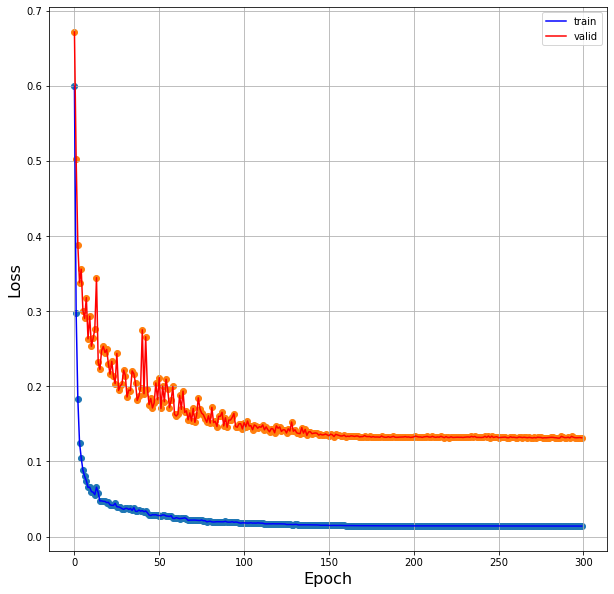

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.plot(range(len(train_losses)), train_losses, label = 'train', color = 'blue')
plt.scatter(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses, label = 'valid', color = 'red')
plt.scatter(range(len(valid_losses)), valid_losses)
   
plt.xlabel('Epoch', size = 16)
plt.ylabel('Loss', size = 16)
plt.grid(True)
plt.legend()
plt.show()            

## =============== CMPD ===============

* By using representational model trained on QM9 dataset, we could fine tune our classification model on the given cmpd dataset.



### Library Import



In [20]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt    
%matplotlib inline
      
import cv2
from tqdm import tqdm

import rdkit 
import rdkit.Chem as Chem
import rdkit.Chem.Draw as Draw
import rdkit.Chem.AllChem as AllChem
import rdkit.RDLogger as RDLogger
RDLogger.DisableLog('rdApp.')

import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Load Data



In [21]:
df = pd.read_csv('/content/drive/MyDrive/Temp/cmpd.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df['label'] = df['activity'].eq('active').astype('float')
df

,inchikey,smiles,group,activity,mol,label
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdf724e0>,1.0
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdf72670>,1.0
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdf72620>,1.0
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdf725d0>,1.0
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdf726c0>,1.0
...,...,...,...,...,...,...
5525,UBAHPEHGSJRHGA-UHFFFAOYSA-N,Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdef1d50>,0.0
5526,RTTIKBHDHKOSNI-UHFFFAOYSA-N,Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdef1da0>,0.0
5527,HVUOSZANYULBJR-UHFFFAOYSA-N,Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdef1df0>,0.0
5528,SNFWCJIVWUVRNO-UHFFFAOYSA-N,N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fdef1e40>,0.0


### Study Molecule Featurizations

* Onehot representations - RDK, Morgans
* Word Embedding representation
* Graph representation



In [22]:
# molecule example
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'  # Smiles representation
mol = Chem.MolFromSmiles(caffeine_smiles)         # Convert to Molecule object

print('Inspect Atomic Information')
for atom in mol.GetAtoms():
    print(f'Idx: {atom.GetIdx():02d}, AtomNum: {atom.GetAtomicNum()}, Aromatic: {atom.GetIsAromatic()}\tSym: {atom.GetSymbol()}')

print('\n')

print('Inspect Bonding Information')
for bond in mol.GetBonds():
    print(f'Src: {bond.GetBeginAtomIdx():02d}, Dst: {bond.GetEndAtomIdx():02d}, Type: {bond.GetBondType()}')

Inspect Atomic Information
Idx: 00, AtomNum: 6, Aromatic: False	Sym: C
Idx: 01, AtomNum: 7, Aromatic: True	Sym: N
Idx: 02, AtomNum: 6, Aromatic: True	Sym: C
Idx: 03, AtomNum: 7, Aromatic: True	Sym: N
Idx: 04, AtomNum: 6, Aromatic: True	Sym: C
Idx: 05, AtomNum: 6, Aromatic: True	Sym: C
Idx: 06, AtomNum: 6, Aromatic: True	Sym: C
Idx: 07, AtomNum: 8, Aromatic: False	Sym: O
Idx: 08, AtomNum: 7, Aromatic: True	Sym: N
Idx: 09, AtomNum: 6, Aromatic: True	Sym: C
Idx: 10, AtomNum: 8, Aromatic: False	Sym: O
Idx: 11, AtomNum: 7, Aromatic: True	Sym: N
Idx: 12, AtomNum: 6, Aromatic: False	Sym: C
Idx: 13, AtomNum: 6, Aromatic: False	Sym: C


Inspect Bonding Information
Src: 00, Dst: 01, Type: SINGLE
Src: 01, Dst: 02, Type: AROMATIC
Src: 02, Dst: 03, Type: AROMATIC
Src: 03, Dst: 04, Type: AROMATIC
Src: 04, Dst: 05, Type: AROMATIC
Src: 05, Dst: 06, Type: AROMATIC
Src: 06, Dst: 07, Type: DOUBLE
Src: 06, Dst: 08, Type: AROMATIC
Src: 08, Dst: 09, Type: AROMATIC
Src: 09, Dst: 10, Type: DOUBLE
Src: 09, Dst

#### Molecular Fingerprint from Smiles



In [23]:
from rdkit.Chem import RDKFingerprint, rdMolDescriptors  # one-hot representations

# RDK Fingerprint
fingerprint_rdk = RDKFingerprint(mol)
print('RDK Fingerprint = {}'.format(fingerprint_rdk))

fingerprint_rdk_np = np.array(fingerprint_rdk)
print('RDK Fingerprint numpy : {}'.format(fingerprint_rdk_np))
print('RDK Fingerprint numpy shape : {}'.format(fingerprint_rdk_np.shape))

print('\n--------------------------------------')

# Morgan Fingerprint
fingerprint_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius = 2)
print('Morgan Fingerprint : {}'.format(fingerprint_morgan))

fingerprint_morgan_np = np.array(fingerprint_morgan)
print('Morgan Fingerprint in numpy : {}'.format(fingerprint_morgan_np))
print('Morgan Fingerprint in numpy shape : {}'.format(fingerprint_morgan_np.shape))

RDK Fingerprint = <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fc7fdeba3f0>
RDK Fingerprint numpy : [1 1 0 ... 0 0 1]
RDK Fingerprint numpy shape : (2048,)

--------------------------------------
Morgan Fingerprint : <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fc7fdeba760>
Morgan Fingerprint in numpy : [0 0 0 ... 0 0 0]
Morgan Fingerprint in numpy shape : (2048,)


#### Onehot Encoding at character level in NLP



In [24]:
# define SMILES characters ----------------------------------------------------
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']

# Encoder / Decoder
smile2index = dict((char, idx) for idx, char in enumerate(SMILES_CHARS))
index2smile = dict((idx, char) for idx, char in enumerate(SMILES_CHARS))

In [25]:
def smiles_encoder(smiles, maxlen = 120): 
    X = np.zeros((maxlen, len(SMILES_CHARS)))
    for idx, char in enumerate(smiles):
        X[idx, smile2index[char]] = 1
    return X

def smiles_decoder(X):
    smiles = ''
    X = X.argmax(axis = -1)
    for idx in X:
        smiles += index2smile[idx] # add char corresponding to idx
    return smiles

In [26]:
# Encoding / Decoding Test
caffeine_encoding = smiles_encoder(caffeine_smiles)
print('Encoding : {}'.format(caffeine_encoding))

print('Decoding : {}'.format(smiles_decoder(caffeine_encoding)))
smiles_decoder(smiles_encoder(caffeine_smiles)).strip() == caffeine_smiles  # It should be True

Encoding : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Decoding : CN1C=NC2=C1C(=O)N(C(=O)N2C)C                                                                                            


True

#### Generating Molecular Representation in Graph



In [27]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
# Caffeine example
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

In [29]:
def molecule_to_graph(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), atomic_num = atom.GetAtomicNum(), 
                   is_aromatic = atom.GetIsAromatic(), atom_symbol = atom.GetSymbol())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type = bond.GetBondType())
    return G

# Convert to graph
caffeine_nx = molecule_to_graph(caffeine_mol) # networkx object

In [30]:
# Node Attributes
caffeine_atom = nx.get_node_attributes(caffeine_nx, 'atom_symbol')
caffeine_atom

{0: 'C',
 1: 'N',
 2: 'C',
 3: 'N',
 4: 'C',
 5: 'C',
 6: 'C',
 7: 'O',
 8: 'N',
 9: 'C',
 10: 'O',
 11: 'N',
 12: 'C',
 13: 'C'}

In [31]:
caffeine_bond = nx.get_edge_attributes(caffeine_nx, 'bond_type')
caffeine_bond

{(0, 1): rdkit.Chem.rdchem.BondType.SINGLE,
 (1, 2): rdkit.Chem.rdchem.BondType.AROMATIC,
 (1, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (2, 3): rdkit.Chem.rdchem.BondType.AROMATIC,
 (3, 4): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (5, 6): rdkit.Chem.rdchem.BondType.AROMATIC,
 (6, 7): rdkit.Chem.rdchem.BondType.DOUBLE,
 (6, 8): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 9): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 13): rdkit.Chem.rdchem.BondType.SINGLE,
 (9, 10): rdkit.Chem.rdchem.BondType.DOUBLE,
 (9, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (11, 12): rdkit.Chem.rdchem.BondType.SINGLE}

In [32]:
# Graph Embedding
from karateclub import Graph2Vec

In [33]:
df = pd.read_csv('/content/drive/MyDrive/Temp/cmpd.csv')
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df['graph'] = df['mol'].apply(lambda x: molecule_to_graph(x))
df['label'] = df['activity'].eq('active').astype('float')
df

,inchikey,smiles,group,activity,mol,graph,label
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa41f0d0>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.0
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa4205d0>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.0
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa420620>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.0
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa420f30>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.0
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa420580>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.0
...,...,...,...,...,...,...,...
5525,UBAHPEHGSJRHGA-UHFFFAOYSA-N,Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa225a80>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
5526,RTTIKBHDHKOSNI-UHFFFAOYSA-N,Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa225ad0>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
5527,HVUOSZANYULBJR-UHFFFAOYSA-N,Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa225b20>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
5528,SNFWCJIVWUVRNO-UHFFFAOYSA-N,N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7fa225b70>,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0


In [34]:
df_train = df[df['group'] == 'train']
df_test  = df[df['group'] == 'test']

In [35]:
model = Graph2Vec()
model.fit(df_train['graph'])
train_embeddings = model.get_embedding()

model = Graph2Vec()
model.fit(df_test['graph'])
test_embeddings = model.get_embedding()

train_labels = df_train['label'].to_numpy()
test_labels = df_test['label'].to_numpy()

### Graph Based MPNN Model



In [36]:
df = pd.read_csv('/content/drive/MyDrive/Temp/cmpd.csv')

# remove 'unknown' and 'intermediate' labels
unknown_idx = df[df['activity'] == 'unknown'].index
intermediate_idx = df[df['activity'] == 'intermediate'].index
df = df.drop(unknown_idx)
df = df.drop(intermediate_idx)

df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df['label'] = df['activity'].eq('active').astype('int')
df

,inchikey,smiles,group,activity,mol,label
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7ee551440>,1
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7ee53ea80>,1
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7ee53ef30>,1
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7ee52fda0>,1
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active,<rdkit.Chem.rdchem.Mol object at 0x7fc7ee52fd00>,1
...,...,...,...,...,...,...
5525,UBAHPEHGSJRHGA-UHFFFAOYSA-N,Cc1cccc2nc(-c3ccc(-c4cccc(CN5CCC(C(N)=O)CC5)c4...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7efa32e40>,0
5526,RTTIKBHDHKOSNI-UHFFFAOYSA-N,Cc1c2ccccc2nc2c1c1cc(NCCN(C)C)ccc1n2CCN(C)C,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7efa32e90>,0
5527,HVUOSZANYULBJR-UHFFFAOYSA-N,Cc1ccc(-c2ccn(-c3ccc4c5c(n(C)c4c3)CCCNC5)c(=O)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7efa32ee0>,0
5528,SNFWCJIVWUVRNO-UHFFFAOYSA-N,N#Cc1c(-c2ccccc2C(F)(F)F)nc(SCc2ccc(OC(F)(F)F)...,test,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fc7efa32f30>,0


In [37]:
df_train = df[df['group'] == 'train']
df_test = df[df['group'] == 'test']

#### Preprocessing to sample



In [38]:
# Caffeine Example
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

In [39]:
def molecule_to_graph(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), atomic_num = atom.GetAtomicNum(), 
                   is_aromatic = atom.GetIsAromatic(), atom_symbol = atom.GetSymbol())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type = bond.GetBondType())
    return G

# Convert to graph
caffeine_nx = molecule_to_graph(caffeine_mol) # networkx object

In [40]:
# given each index, each atomic number of nodes in a graph, we can generate initial Node Attributes Matrix.
import json
with open('/content/drive/MyDrive/cgcnn/data/sample-regression/atom_init.json') as f:
    element_embedding = json.load(f)
print('Element Embedding Keys : {}'.format(element_embedding.keys())) # Atomic Numbers from 1 to 100


# All Embedding Vectors are 92-dimensional.
dimensions = []
for key, value in element_embedding.items():
    dimensions.append(len(value))
print('Dimension of Each Embedding Vectors : {}'.format(dimensions))

# Key(Atomic Number) convert from 'string' to 'integer'.
element_embedding = {int(key) : value for key, value in element_embedding.items()}
print('Element Embedding Keys : {}'.format(element_embedding.keys()))


atom_types = set(element_embedding.keys())   # Set --> remove duplicated number
print('Atom Types : {}'.format(atom_types))  # Set of Atomic Numbers from 1 to 100

# Initial Embedding Vectors per atoms --> Dictionary Saved.
embedding_dict = {}
for key, value in element_embedding.items():
    embedding_dict[key] = np.array(value, dtype = float) # value(list) --> np.array 변환

Element Embedding Keys : dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100'])
Dimension of Each Embedding Vectors : [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 

In [41]:
# Node Attributes
caffeine_atom = nx.get_node_attributes(caffeine_nx, 'atomic_num') # Access to Atomic Number
caffeine_atom

{0: 6,
 1: 7,
 2: 6,
 3: 7,
 4: 6,
 5: 6,
 6: 6,
 7: 8,
 8: 7,
 9: 6,
 10: 8,
 11: 7,
 12: 6,
 13: 6}

In [42]:
# Stacked numpy array with initial atomic embedding vectors
node_attributes = [embedding_dict[atomic_number] for node_index, atomic_number in caffeine_atom.items()]
node_attributes = np.array(node_attributes)
print(node_attributes.shape)

(14, 92)


In [43]:
# edge index, edge attr
caffeine_bond = nx.get_edge_attributes(caffeine_nx, 'bond_type') # Access to Bond Type
caffeine_bond

{(0, 1): rdkit.Chem.rdchem.BondType.SINGLE,
 (1, 2): rdkit.Chem.rdchem.BondType.AROMATIC,
 (1, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (2, 3): rdkit.Chem.rdchem.BondType.AROMATIC,
 (3, 4): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 5): rdkit.Chem.rdchem.BondType.AROMATIC,
 (4, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (5, 6): rdkit.Chem.rdchem.BondType.AROMATIC,
 (6, 7): rdkit.Chem.rdchem.BondType.DOUBLE,
 (6, 8): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 9): rdkit.Chem.rdchem.BondType.AROMATIC,
 (8, 13): rdkit.Chem.rdchem.BondType.SINGLE,
 (9, 10): rdkit.Chem.rdchem.BondType.DOUBLE,
 (9, 11): rdkit.Chem.rdchem.BondType.AROMATIC,
 (11, 12): rdkit.Chem.rdchem.BondType.SINGLE}

In [44]:
for src_to_dst, bond_type in caffeine_bond.items():
    print(src_to_dst, bond_type)

(0, 1) SINGLE
(1, 2) AROMATIC
(1, 5) AROMATIC
(2, 3) AROMATIC
(3, 4) AROMATIC
(4, 5) AROMATIC
(4, 11) AROMATIC
(5, 6) AROMATIC
(6, 7) DOUBLE
(6, 8) AROMATIC
(8, 9) AROMATIC
(8, 13) SINGLE
(9, 10) DOUBLE
(9, 11) AROMATIC
(11, 12) SINGLE


In [45]:
# adjacency matrix부터 해보자!
edge_index = []
edge_attr = []

for src_to_dst, bond_type in caffeine_bond.items():
    edge_index.append(list(src_to_dst)) # source node index, destination node index
    temp = F.one_hot(torch.tensor(bond_type.real), num_classes = len(bond_type.values)).to(torch.float)
    edge_attr.append(list(temp)) # Bond Type number as edge weight
print('Edge Index Shape : {}'.format(np.array(edge_index).shape))

# ------------------------------------------------------------------
undirected_edge_index = []
for i in range(len(edge_index)):
    src, dst = edge_index[i]
    inverse_edge = torch.Tensor([dst, src])
    out = torch.cat([torch.Tensor(edge_index[i]), inverse_edge]).view(-1, 2).long().numpy()
    undirected_edge_index.append(out)

undirected_edge_index = np.array(undirected_edge_index)
undirected_edge_index = torch.Tensor(undirected_edge_index).view(-1, 2)
undirected_edge_index = undirected_edge_index.t().long()
print('Undirected Edge Index Shape : {}'.format(undirected_edge_index.shape))

# --------------------------------------------------------------------
undirected_edge_attr = []

for i in range(len(edge_attr)):
    undirected_edge_attr.append(edge_attr[i]) # To make 'Data' object in PyG --> 'undirected'
    undirected_edge_attr.append(edge_attr[i])

undirected_edge_attr = torch.Tensor(undirected_edge_attr).view(-1, 22)
print('Undirected Edge Attr Shape : {}'.format(undirected_edge_attr.shape))

Edge Index Shape : (15, 2)
Undirected Edge Index Shape : torch.Size([2, 30])
Undirected Edge Attr Shape : torch.Size([30, 22])


In [46]:
from torch_geometric.data import Data
from torch_geometric.utils.undirected import to_undirected

In [47]:
data = Data(x = node_attributes, edge_index = undirected_edge_index, edge_attr = undirected_edge_attr,
            y = None, pos = None, num_nodes = len(node_attributes))
print(data)
print('=======================================================')

# Gather some statistics about the graph.
print('Number of nodes : {}'.format(data.num_nodes))
print('Number of edges : {}'.format(data.num_edges))
print('Average node degree : {:.2f}'.format(data.num_edges / data.num_nodes))

# Methods
print('Has isolated nodes : {}'.format(data.has_isolated_nodes())) 
print('Has self-loops : {}'.format(data.has_self_loops())) 
print('Is undirected : {}'.format(data.is_undirected()))

Data(x=[14, 92], edge_index=[2, 30], edge_attr=[30, 22], num_nodes=14)
Number of nodes : 14
Number of edges : 30
Average node degree : 2.14
Has isolated nodes : False
Has self-loops : False
Is undirected : True


#### CustomDataset

* Preprocessing to Total Dataset



In [48]:
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader # Automatic Graph Batching

In [49]:
class CustomDataset(Dataset):

    def __init__(self, DataFrame = None):
        super().__init__()
        self.df = DataFrame 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        mol = self.df.iloc[idx]['mol']     # Molecule object
        nx_graph = molecule_to_graph(mol)  # Nx Graph
        
        # ------------------------ Node Attributes -----------------------------
        node_attributes = nx.get_node_attributes(nx_graph, 'atomic_num') # Access to Atomic number
        node_attributes = [embedding_dict[atomic_number] for node_index, atomic_number in node_attributes.items()]
        node_attributes = np.array(node_attributes)
        node_attributes = torch.Tensor(node_attributes)
        
        # ----------------------- edge index, edge attr ------------------------
        edge_attributes = nx.get_edge_attributes(nx_graph, 'bond_type') # Access to Bond Type
    
        # adjacency matrix부터 해보자!
        edge_index = []
        edge_attr = []

        for src_to_dst, bond_type in edge_attributes.items():
            edge_index.append(list(src_to_dst)) # source node index, destination node index
            temp = F.one_hot(torch.tensor(bond_type.real), num_classes = len(bond_type.values)).to(torch.float)
            edge_attr.append(list(temp)) # Bond Type number as edge weight

        # ------------------------------------------------------------------
        undirected_edge_index = []
        for i in range(len(edge_index)):
            src, dst = edge_index[i]
            inverse_edge = torch.Tensor([dst, src])
            out = torch.cat([torch.Tensor(edge_index[i]), inverse_edge]).view(-1, 2).long().numpy()
            undirected_edge_index.append(out)

        undirected_edge_index = np.array(undirected_edge_index)
        undirected_edge_index = torch.Tensor(undirected_edge_index).view(-1, 2)
        undirected_edge_index = undirected_edge_index.t().long()

        # --------------------------------------------------------------------
        undirected_edge_attr = []
        for i in range(len(edge_attr)):
            undirected_edge_attr.append(edge_attr[i]) # To make 'Data' object in PyG --> 'undirected'
            undirected_edge_attr.append(edge_attr[i])

        undirected_edge_attr = torch.Tensor(undirected_edge_attr).view(-1, 22)
        # -------------------------------------------------------------------------
        y = torch.tensor(self.df.iloc[idx]['label'])

        data = Data(x = node_attributes, edge_index = undirected_edge_index, edge_attr = undirected_edge_attr,
                    y = y, pos = None, num_nodes = len(node_attributes))
        return data

custom_dataset = CustomDataset(DataFrame = df_train)
print('example : {}'.format(custom_dataset[2]))

example : Data(x=[25, 92], edge_index=[2, 56], edge_attr=[56, 22], y=1, num_nodes=25)


In [50]:
train_dataset = CustomDataset(df_train)
test_dataset  = CustomDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True,  pin_memory = True, num_workers = 2)
test_loader  = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

print('Number of Train Dataset : {}'.format(len(train_loader.dataset)))
print('Number of Test Dataset : {}'.format(len(test_loader.dataset)))

sample = next(iter(train_loader))
print('Sample : {}'.format(sample))  # Check Batch Sample

Number of Train Dataset : 3221
Number of Test Dataset : 1369
Sample : DataBatch(x=[992, 92], edge_index=[2, 2194], edge_attr=[2194, 22], y=[32], num_nodes=992, batch=[992], ptr=[33])


#### Modeling



In [51]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, CGConv # CGCNN CONV
from torch_geometric.nn import global_mean_pool

from tqdm import tqdm
import shutil
import time

#### model reload



In [52]:
# --------------------------------- Model Reload -------------------------------------------------
reload_model = MPNN().to(device)
model_path = '/content/drive/MyDrive/Temp/BestMPNN-QM9.pth'
reload_model.load_state_dict(torch.load(model_path))
reload_model.eval()
print(reload_model)

MPNN(
  (node_embedding): Linear(in_features=11, out_features=92, bias=True)
  (edge_embedding): Linear(in_features=5, out_features=22, bias=True)
  (lin0): Linear(in_features=92, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)


In [53]:
# Check list of trained layers
modules = list(reload_model.children())[:]
for i, layer in enumerate(modules):
    print(i, layer)

0 Linear(in_features=11, out_features=92, bias=True)
1 Linear(in_features=5, out_features=22, bias=True)
2 Linear(in_features=92, out_features=64, bias=True)
3 NNConv(64, 64, aggr=mean, nn=Sequential(
  (0): Linear(in_features=22, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=4096, bias=True)
))
4 GRU(64, 64)
5 Set2Set(64, 128)
6 Linear(in_features=128, out_features=64, bias=True)
7 Linear(in_features=64, out_features=1, bias=True)


In [54]:
class MPNNClassifier(torch.nn.Module):
    
    def __init__(self, dim = 64):
        super().__init__()
        modules = list(reload_model.children())[:]  # load pretrained MPNN layers
        self.node_embedding_layer2 = modules[2]     # 92 -> 64
        self.nnconv_layer3 = modules[3]             # layer 3
        self.gru_layer4 = modules[4]                # layer 4
        self.set2set_layer5 = modules[5]            # layer 5
        self.lin1_layer6 = modules[6]               # layer 6
        # -----------------------------------------------------------------------
        self.lin2_layer7 = torch.nn.Linear(dim, 1)  # finetuned layer

    def forward(self, data):
        # ----------------------------------------------------------------------------
        out = F.relu(self.node_embedding_layer2(data.x)) # node dimension --> dim 
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.nnconv_layer3(out, data.edge_index, data.edge_attr)) # MPNN Convolution : dim 
            out, h = self.gru_layer4(m.unsqueeze(0), h) # dim 유지
            out = out.squeeze(0)
        out = self.set2set_layer5(out, data.batch) # dim -> 2 * dim
        h = out                                    # final embedding
        out = F.relu(self.lin1_layer6(out))        # 2 * dim --> dim
        # -----------------------------------------------------------------
        out = F.dropout(out, p = 0.5)
        out = self.lin2_layer7(out)                # dim --> 1
        return torch.sigmoid(out.view(-1)), h

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNNClassifier().to(device) # Pretrained MPNN
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.BCELoss() # with sigmoid
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max',
                                                       factor = 0.5, patience = 3, min_lr = 0.00001) # LR Scheduler
print('Model : {}'.format(model))
print('Criterion : {}'.format(criterion))
print('Optimizer : {}'.format(optimizer))
print('Scheduler : {}'.format(scheduler))

batch_data = next(iter(train_loader))
batch_data = batch_data.to(device)
out, _ = model(batch_data)

Model : MPNNClassifier(
  (node_embedding_layer2): Linear(in_features=92, out_features=64, bias=True)
  (nnconv_layer3): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru_layer4): GRU(64, 64)
  (set2set_layer5): Set2Set(64, 128)
  (lin1_layer6): Linear(in_features=128, out_features=64, bias=True)
  (lin2_layer7): Linear(in_features=64, out_features=1, bias=True)
)
Criterion : BCELoss()
Optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
)
Scheduler : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fc7eed5c5d0>


#### Training / Validation



In [56]:
model_path = '/content/drive/MyDrive/Temp/BionsightModel.pth' 
num_epochs = 30
avg_train_losses = [] # To plot loss graph
avg_test_losses = []
avg_test_accs = []
start_time = time.time()
for epoch in range(num_epochs):

    # ------------------------------------ Training -----------------------------------------------
    model.train()
    training_loss = 0
    for batch_data in tqdm(train_loader):
        optimizer.zero_grad()
        batch_data = batch_data.to(device)
        target = batch_data.y.float()                 
        
        out, h = model(batch_data) # proba value with sigmoid
        assert out.shape == target.shape, 'Shapes are different!!'
        loss = criterion(out, target) # BCE
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    average_training_loss = training_loss / len(train_loader.dataset)
    avg_train_losses.append(average_training_loss)

    # -------------------------------- Validatation ----------------------------------------------
    model.eval()
    test_loss = 0
    test_corrects = []
    for batch_data in tqdm(test_loader):
        batch_data = batch_data.to(device)
        target = batch_data.y.long()

        out, h = model(batch_data)  # proba value with sigmoid
        assert out.shape == target.shape, 'Shapes are different!!'
        loss = criterion(out, target.float())

        pred = torch.round(out).long()               # 0 or 1
        correct = int((pred == target).sum())        # number of True
        test_corrects.append(correct / len(target))  # accuracy per batch data
        test_loss += loss.item()

    average_test_acc = np.array(test_corrects).sum() / len(test_corrects) # avg test accuracy per epoch
    average_test_loss = test_loss / len(test_loader.dataset)

    avg_test_accs.append(average_test_acc)
    avg_test_losses.append(average_test_loss)
    
    print('Epoch: [{:02d}/{:02d}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Validation Acc: {:.6f}'.format(
        epoch + 1, num_epochs, average_training_loss, average_test_loss, average_test_acc))
    # --------------------------------------------------------------------------------------------
    scheduler.step(np.array(test_corrects).sum() / len(test_corrects)) # LR Scheduler
    
print('\nElapsed Time : {:.4f} secs'.format(time.time() - start_time)) 
print('Training Completed!')

100%|██████████| 43/43 [00:08<00:00,  4.90it/s]


Epoch: [01/30], Training Loss: 0.020205, Validation Loss: 0.026062, Validation Acc: 0.405523


100%|██████████| 43/43 [00:06<00:00,  6.17it/s]


Epoch: [02/30], Training Loss: 0.020084, Validation Loss: 0.024964, Validation Acc: 0.405523


100%|██████████| 43/43 [00:07<00:00,  5.71it/s]


Epoch: [03/30], Training Loss: 0.020049, Validation Loss: 0.025018, Validation Acc: 0.405523


100%|██████████| 43/43 [00:06<00:00,  6.15it/s]


Epoch: [04/30], Training Loss: 0.019947, Validation Loss: 0.023551, Validation Acc: 0.405523


100%|██████████| 43/43 [00:06<00:00,  6.34it/s]


Epoch: [05/30], Training Loss: 0.019222, Validation Loss: 0.022337, Validation Acc: 0.496337


100%|██████████| 43/43 [00:06<00:00,  6.17it/s]


Epoch: [06/30], Training Loss: 0.018597, Validation Loss: 0.025153, Validation Acc: 0.428459


100%|██████████| 43/43 [00:06<00:00,  6.29it/s]


Epoch: [07/30], Training Loss: 0.018204, Validation Loss: 0.026153, Validation Acc: 0.420785


100%|██████████| 43/43 [00:06<00:00,  6.34it/s]


Epoch: [08/30], Training Loss: 0.017826, Validation Loss: 0.021460, Validation Acc: 0.614564


100%|██████████| 43/43 [00:06<00:00,  6.22it/s]


Epoch: [09/30], Training Loss: 0.017801, Validation Loss: 0.022213, Validation Acc: 0.562762


100%|██████████| 43/43 [00:07<00:00,  5.49it/s]


Epoch: [10/30], Training Loss: 0.017173, Validation Loss: 0.028851, Validation Acc: 0.489913


100%|██████████| 43/43 [00:06<00:00,  6.34it/s]


Epoch: [11/30], Training Loss: 0.017281, Validation Loss: 0.022536, Validation Acc: 0.594942


100%|██████████| 43/43 [00:07<00:00,  6.13it/s]


Epoch: [12/30], Training Loss: 0.017180, Validation Loss: 0.021828, Validation Acc: 0.561628


100%|██████████| 43/43 [00:07<00:00,  6.14it/s]


Epoch: [13/30], Training Loss: 0.016668, Validation Loss: 0.022488, Validation Acc: 0.581453


100%|██████████| 43/43 [00:06<00:00,  6.20it/s]


Epoch: [14/30], Training Loss: 0.016536, Validation Loss: 0.021927, Validation Acc: 0.608227


100%|██████████| 43/43 [00:06<00:00,  6.50it/s]


Epoch: [15/30], Training Loss: 0.016361, Validation Loss: 0.020891, Validation Acc: 0.629709


100%|██████████| 43/43 [00:07<00:00,  5.75it/s]


Epoch: [16/30], Training Loss: 0.016268, Validation Loss: 0.021954, Validation Acc: 0.620988


100%|██████████| 43/43 [00:06<00:00,  6.46it/s]


Epoch: [17/30], Training Loss: 0.016297, Validation Loss: 0.021865, Validation Acc: 0.613721


100%|██████████| 43/43 [00:06<00:00,  6.36it/s]


Epoch: [18/30], Training Loss: 0.016087, Validation Loss: 0.023233, Validation Acc: 0.608547


100%|██████████| 43/43 [00:06<00:00,  6.24it/s]


Epoch: [19/30], Training Loss: 0.015935, Validation Loss: 0.023971, Validation Acc: 0.588721


100%|██████████| 43/43 [00:07<00:00,  5.70it/s]


Epoch: [20/30], Training Loss: 0.015722, Validation Loss: 0.020480, Validation Acc: 0.667907


100%|██████████| 43/43 [00:07<00:00,  5.51it/s]


Epoch: [21/30], Training Loss: 0.015524, Validation Loss: 0.023537, Validation Acc: 0.640727


100%|██████████| 43/43 [00:08<00:00,  5.31it/s]


Epoch: [22/30], Training Loss: 0.015550, Validation Loss: 0.023248, Validation Acc: 0.621628


100%|██████████| 43/43 [00:07<00:00,  5.66it/s]


Epoch: [23/30], Training Loss: 0.015464, Validation Loss: 0.020806, Validation Acc: 0.659506


100%|██████████| 43/43 [00:07<00:00,  6.05it/s]


Epoch: [24/30], Training Loss: 0.015375, Validation Loss: 0.020778, Validation Acc: 0.662093


100%|██████████| 43/43 [00:06<00:00,  6.15it/s]


Epoch: [25/30], Training Loss: 0.015146, Validation Loss: 0.020943, Validation Acc: 0.668430


100%|██████████| 43/43 [00:06<00:00,  6.19it/s]


Epoch: [26/30], Training Loss: 0.014902, Validation Loss: 0.021699, Validation Acc: 0.670203


100%|██████████| 43/43 [00:06<00:00,  6.28it/s]


Epoch: [27/30], Training Loss: 0.014860, Validation Loss: 0.020189, Validation Acc: 0.677355


100%|██████████| 43/43 [00:07<00:00,  5.49it/s]


Epoch: [28/30], Training Loss: 0.014869, Validation Loss: 0.021575, Validation Acc: 0.678198


100%|██████████| 43/43 [00:06<00:00,  6.16it/s]


Epoch: [29/30], Training Loss: 0.014812, Validation Loss: 0.021238, Validation Acc: 0.681831


100%|██████████| 43/43 [00:06<00:00,  6.18it/s]

Epoch: [30/30], Training Loss: 0.014939, Validation Loss: 0.020911, Validation Acc: 0.682355

Elapsed Time : 464.7732 secs
Training Completed!


#### Results

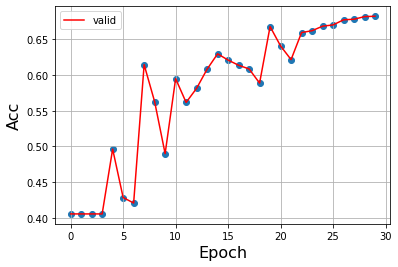

In [58]:
plt.plot(range(num_epochs), avg_test_accs, label = 'valid', color = 'red')
plt.scatter(range(num_epochs), avg_test_accs)
plt.xlabel('Epoch', size = 16)
plt.ylabel('Acc', size = 16)
plt.grid(True)
plt.legend()
plt.show()

## End

* I couldn't obtain sharp results Since I don't have much chemistry knowledge to preprocess molecule information.

* I've used initial atomic embedding information which has been generated in https://mendeleev.readthedocs.io/en/stable/, and it is given as json.file in this code.

* I've trained MPNN model first, using QM9 dataset which contains about 130,000 molecule structure and 13 regression properties. After that, I've fine tune the second classifier model.

### Thank you!
